In [ ]:
%cd ..
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from rdkit import Chem

In [2]:
from src.utils.extra import notation_table

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.evaluator import Evaluator, ForwardEvaluator, BackwardEvaluator

## Loading Evaluators

In [ ]:
bestof_forward_setup = pd.read_csv('bestof_setup/best_forward_settings.csv')
bestof_backward_setup = pd.read_csv('bestof_setup/best_backward_settings.csv')

In [6]:
bestof_forward_setup

,model_dim,num_heads,num_layers,batch_size,lr,dropout,notation,task
0,512,4,5,256,0.0001,0.3,fragsmiles,forward
1,512,4,5,256,0.0001,0.3,safe,forward
2,256,4,3,512,0.0010,0.3,selfies,forward
3,256,4,4,512,0.0010,0.3,smiles,forward


In [7]:
def load_everything(evaluator):

    if mask_preds:=evaluator.load_pred_tokens() is False:
        return None
        
    if mask_mols:=evaluator.load_mols() is False:
        return None

    if mask_mols:=evaluator.load_mols_strict() is False:
        return None

    return evaluator

In [8]:
evaluators_forward = {
    kwargs['notation']:Evaluator.from_dict_args(kwargs)
    for kwargs in bestof_forward_setup.astype(str).to_dict('records')
}

In [9]:
evaluators_backward = {
    kwargs['notation']:Evaluator.from_dict_args(kwargs)
    for kwargs in bestof_backward_setup.astype(str).to_dict('records')
}

In [10]:
for evaluator in evaluators_forward.values():
    load_everything(evaluator)

In [11]:
for evaluator in evaluators_backward.values():
    load_everything(evaluator)

# Extra functions

In [12]:
from src.utils.extra import as_percent_str, annotate_heatmap

In [13]:
from jinja2 import Environment, FileSystemLoader

env = Environment(
    loader=FileSystemLoader('.'),
)

In [14]:
NOTATIONS = notation_table['name']
from itertools import combinations
def overlap_accurates(dict_evaluators, k, chirality=False):
    adj = pd.DataFrame(index=NOTATIONS, columns=NOTATIONS)
    adj = adj.map(lambda x: 0.0)

    for (not1,ev1),(not2,ev2) in combinations(dict_evaluators.items(), 2):
        if not chirality:
            data1=ev1.accurates[:,:k+1].any(axis=1)
            data2=ev2.accurates[:,:k+1].any(axis=1)
        else:
            data1=ev1.chiral_accurates[:,:k+1].any(axis=1)
            data2=ev2.chiral_accurates[:,:k+1].any(axis=1)

        inters = data1 | data2
        union = data1 & data2
        value = union.sum() / inters.sum()

        not1 = notation_table.loc[not1,'name']
        not2 = notation_table.loc[not2,'name']

        adj.at[not1,not2] = value
        adj.at[not2,not1] = value

    return adj

# Accuracy Full dataset

In [15]:
forward_valid=pd.DataFrame.from_dict(
    {
        f'top{k+1}' : {
            notation_table.loc[notation,'name']: evaluator.validity(k)
            for notation, evaluator in evaluators_forward.items()
        }
        for k in range(5)
    }
)

forward_accuracy=pd.DataFrame.from_dict(
    {
        f'top{k+1}' : {
            notation_table.loc[notation,'name']: evaluator.accuracy(k)
            for notation, evaluator in evaluators_forward.items()
        }
        for k in range(5)
    }
)

In [16]:
backward_valid=pd.DataFrame.from_dict(
    {
        f'top{k+1}' : {
            notation_table.loc[notation,'name']: evaluator.validity(k)
            for notation, evaluator in evaluators_backward.items()
        }
        for k in range(5)
    }
)

backward_accuracy=pd.DataFrame.from_dict(
    {
        f'top{k+1}' : {
            notation_table.loc[notation,'name']: evaluator.accuracy(k)
            for notation, evaluator in evaluators_backward.items()
        }
        for k in range(5)
    }
)

In [17]:
forward_accuracy

,top1,top2,top3,top4,top5
fragSMILES,26830,30291,32030,33020,33697
SAFE,15151,18758,20557,21609,22169
SELFIES,10538,13415,14911,15904,16591
SMILES,25053,29264,31136,32308,32991


In [18]:
forward_accuracy

,top1,top2,top3,top4,top5
fragSMILES,26830,30291,32030,33020,33697
SAFE,15151,18758,20557,21609,22169
SELFIES,10538,13415,14911,15904,16591
SMILES,25053,29264,31136,32308,32991


In [19]:
backward_accuracy

,top1,top2,top3,top4,top5
fragSMILES,4230,6128,7587,8904,10089
SAFE,3731,4886,5674,6392,6978
SELFIES,0,0,2,3,3
SMILES,4018,5587,6695,7577,8290


## Strict chirality syntax

In [21]:
forward_valid_strict=pd.DataFrame.from_dict(
    {
        f'top{k+1}' : {
            notation_table.loc[notation,'name']: evaluator.validity(k, strict_chiral=True)
            for notation, evaluator in evaluators_forward.items()
        }
        for k in range(5)
    }
)

forward_accuracy_strict=pd.DataFrame.from_dict(
    {
        f'top{k+1}' : {
            notation_table.loc[notation,'name']: evaluator.accuracy(k, strict_chiral=True)
            for notation, evaluator in evaluators_forward.items()
        }
        for k in range(5)
    }
)

In [22]:
backward_valid_strict=pd.DataFrame.from_dict(
    {
        f'top{k+1}' : {
            notation_table.loc[notation,'name']: evaluator.validity(k, strict_chiral=True)
            for notation, evaluator in evaluators_backward.items()
        }
        for k in range(5)
    }
)

backward_accuracy_strict=pd.DataFrame.from_dict(
    {
        f'top{k+1}' : {
            notation_table.loc[notation,'name']: evaluator.accuracy(k, strict_chiral=True)
            for notation, evaluator in evaluators_backward.items()
        }
        for k in range(5)
    }
)

In [23]:
forward_accuracy_strict

,top1,top2,top3,top4,top5
fragSMILES,26826,30287,32026,33015,33692
SAFE,15151,18758,20557,21609,22169
SELFIES,10538,13415,14911,15904,16591
SMILES,25053,29261,31133,32305,32988


## Overlap Metrics

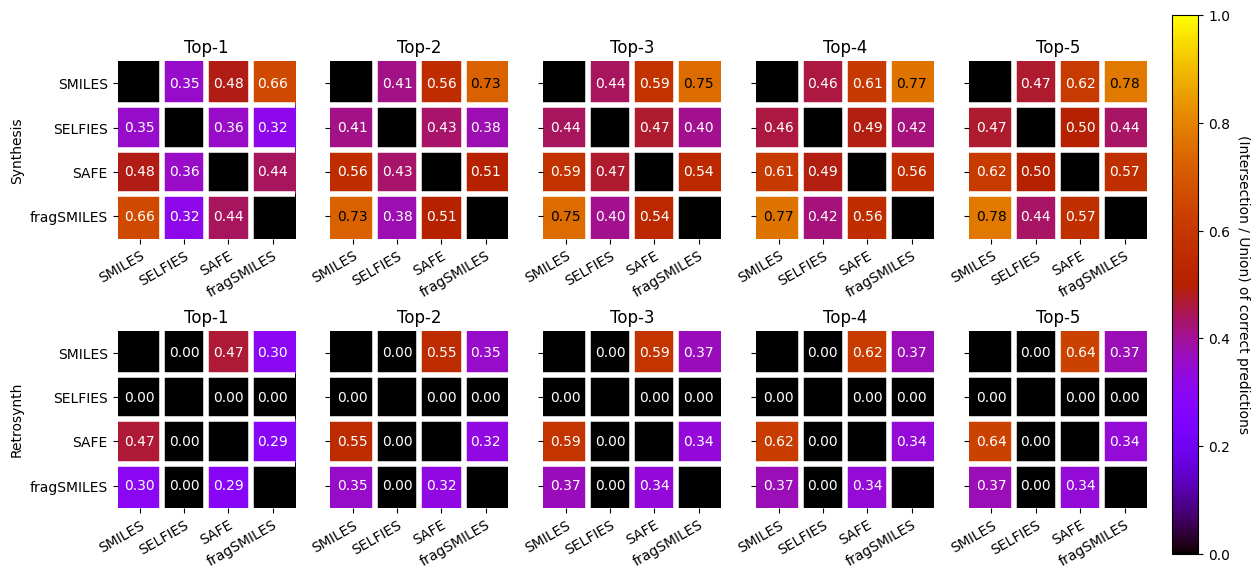

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,7), gridspec_kw={'hspace':.0,}, sharey=True)

ticks = np.arange(len(notation_table))
labels = notation_table.name.tolist()
for row, evaluators in zip(axes, [evaluators_forward, evaluators_backward]):
    for ax, k in zip(row, range(5)):

        adj = overlap_accurates(evaluators, k).values
        
        im = ax.matshow(adj.astype(float), cmap = 'gnuplot', vmin=0.0, vmax=1.0)

        ax.set_xticks(ticks, labels, rotation=30, ha="right", rotation_mode="anchor")
        ax.xaxis.set_ticks_position("bottom")
        ax.set_yticks(ticks, labels)

        ax.set_title(f'Top-{k+1}')

        # Turn spines off and create white grid.
        ax.spines[:].set_visible(False)

        ax.set_xticks(ticks[:-1]+.5, minor=True)
        ax.set_yticks(ticks[:-1]+.5, minor=True)

        ax.grid(which="minor", color="w", linestyle='-', linewidth=4)
        ax.tick_params(which="minor", bottom=False, left=False)

        annotate_heatmap(im, adj, textcolors=("white", "black"), threshold=.7)

axes[0,0].set_ylabel('Synthesis')
axes[1,0].set_ylabel('Retrosynth')

cbar = fig.colorbar(im, ax=axes.flatten(), orientation='vertical', pad = .02, location='right')
cbar.set_label('(Intersection / Union) of correct predictions', rotation=-90, va='bottom')


# Chiral Dataset Accuracy

In [27]:
forward_chiral_valid=pd.DataFrame.from_dict(
    {
        f'top{k+1}' : {
            notation_table.loc[notation,'name']: evaluator.chiral_validity(k)
            for notation, evaluator in evaluators_forward.items()
        }
        for k in range(5)
    }
)

forward_chiral_accuracy=pd.DataFrame.from_dict(
    {
        f'top{k+1}' : {
            notation_table.loc[notation,'name']: evaluator.chiral_accuracy(k)
            for notation, evaluator in evaluators_forward.items()
        }
        for k in range(5)
    }
)

In [28]:
backward_chiral_valid=pd.DataFrame.from_dict(
    {
        f'top{k+1}' : {
            notation_table.loc[notation,'name']: evaluator.chiral_validity(k)
            for notation, evaluator in evaluators_backward.items()
        }
        for k in range(5)
    }
)

backward_chiral_accuracy=pd.DataFrame.from_dict(
    {
        f'top{k+1}' : {
            notation_table.loc[notation,'name']: evaluator.chiral_accuracy(k)
            for notation, evaluator in evaluators_backward.items()
        }
        for k in range(5)
    }
)

In [29]:
forward_chiral_accuracy

,top1,top2,top3,top4,top5
fragSMILES,3805,4349,4656,4830,4962
SAFE,1609,2095,2343,2495,2575
SELFIES,1170,1548,1732,1859,1956
SMILES,3331,4147,4479,4681,4812


In [30]:
forward_chiral_accuracy

,top1,top2,top3,top4,top5
fragSMILES,3805,4349,4656,4830,4962
SAFE,1609,2095,2343,2495,2575
SELFIES,1170,1548,1732,1859,1956
SMILES,3331,4147,4479,4681,4812


In [31]:
backward_chiral_accuracy

,top1,top2,top3,top4,top5
fragSMILES,620,918,1127,1296,1467
SAFE,635,805,924,1048,1125
SELFIES,0,0,0,0,0
SMILES,656,918,1094,1236,1331


## Strict Accuracy chiral

In [33]:
forward_chiral_valid_strict=pd.DataFrame.from_dict(
    {
        f'top{k+1}' : {
            notation_table.loc[notation,'name']: evaluator.chiral_validity(k, strict_chiral=True)
            for notation, evaluator in evaluators_forward.items()
        }
        for k in range(5)
    }
)

forward_chiral_accuracy_strict=pd.DataFrame.from_dict(
    {
        f'top{k+1}' : {
            notation_table.loc[notation,'name']: evaluator.chiral_accuracy(k, strict_chiral=True)
            for notation, evaluator in evaluators_forward.items()
        }
        for k in range(5)
    }
)

In [34]:
backward_chiral_valid_strict=pd.DataFrame.from_dict(
    {
        f'top{k+1}' : {
            notation_table.loc[notation,'name']: evaluator.chiral_validity(k, strict_chiral=True)
            for notation, evaluator in evaluators_backward.items()
        }
        for k in range(5)
    }
)

backward_chiral_accuracy_strict=pd.DataFrame.from_dict(
    {
        f'top{k+1}' : {
            notation_table.loc[notation,'name']: evaluator.chiral_accuracy(k, strict_chiral=True)
            for notation, evaluator in evaluators_backward.items()
        }
        for k in range(5)
    }
)

In [35]:
forward_chiral_accuracy_strict

,top1,top2,top3,top4,top5
fragSMILES,3801,4345,4652,4825,4957
SAFE,1609,2095,2343,2495,2575
SELFIES,1170,1548,1732,1859,1956
SMILES,3331,4144,4476,4678,4809


In [36]:
backward_chiral_accuracy_strict

,top1,top2,top3,top4,top5
fragSMILES,620,919,1128,1297,1469
SAFE,635,805,924,1048,1125
SELFIES,8,19,27,32,43
SMILES,669,933,1108,1249,1343


In [37]:
ForwardEvaluator.true_smiles.chiral.sum()

8588

## Overlap Metrics

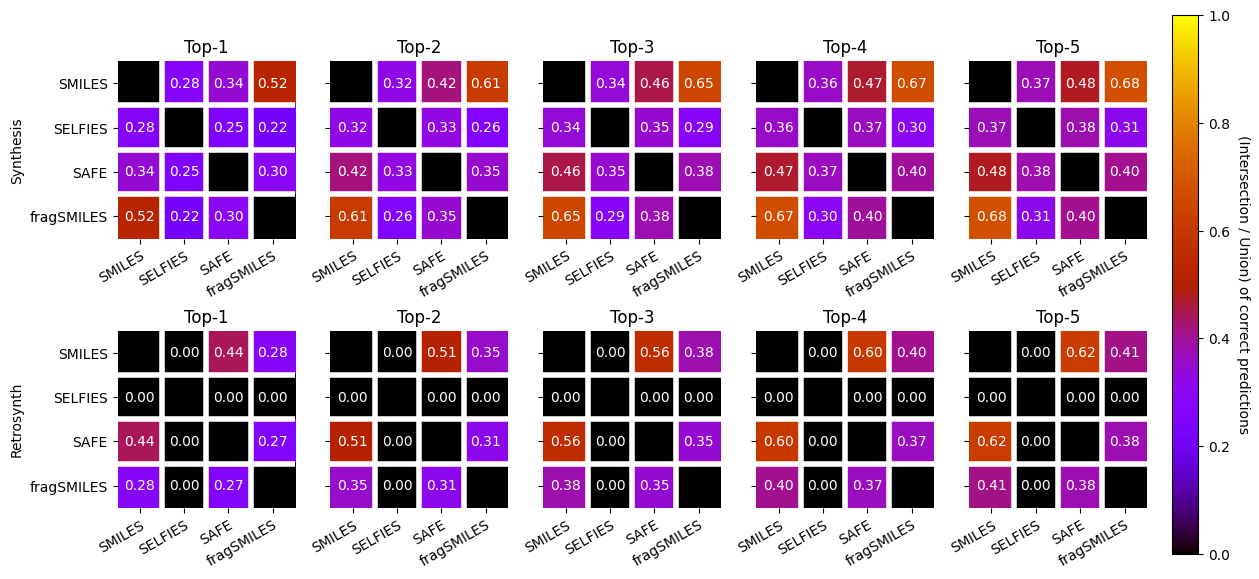

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,7), gridspec_kw={'hspace':.0,}, sharey=True)

ticks = np.arange(len(notation_table))
labels = notation_table.name.tolist()
for row, evaluators in zip(axes, [evaluators_forward, evaluators_backward]):
    for ax, k in zip(row, range(5)):

        adj = overlap_accurates(evaluators, k, chirality=True).values
        
        im = ax.matshow(adj.astype(float), cmap = 'gnuplot', vmin=0.0, vmax=1.0)

        ax.set_xticks(ticks, labels, rotation=30, ha="right", rotation_mode="anchor")
        ax.xaxis.set_ticks_position("bottom")
        ax.set_yticks(ticks, labels)

        ax.set_title(f'Top-{k+1}')

        # Turn spines off and create white grid.
        ax.spines[:].set_visible(False)

        ax.set_xticks(ticks[:-1]+.5, minor=True)
        ax.set_yticks(ticks[:-1]+.5, minor=True)

        ax.grid(which="minor", color="w", linestyle='-', linewidth=4)
        ax.tick_params(which="minor", bottom=False, left=False)

        annotate_heatmap(im, adj, textcolors=("white", "black"), threshold=.7)

axes[0,0].set_ylabel('Synthesis')
axes[1,0].set_ylabel('Retrosynth')

cbar = fig.colorbar(im, ax=axes.flatten(), orientation='vertical', pad = .02, location='right')
cbar.set_label('(Intersection / Union) of correct predictions', rotation=-90, va='bottom')
